# Imports

In [57]:
# sklearn analytics
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
import matplotlib.cm as cm
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# Models
from sklearn import cluster
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering
from sklearn.manifold import TSNE
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import Birch

# Text Preprocessing
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer,\
    TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline


# General
import warnings
import numpy as np
import pandas as pd
import nltk
import random
import os
import re
import string
import statsmodels.api as sm
from os import path
from PIL import Image
from time import time


# NLP
from nltk import sent_tokenize, word_tokenize
from nltk.util import ngrams
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
stop = stopwords.words('english')
from nltk.tokenize import RegexpTokenizer
from wordcloud import WordCloud, STOPWORDS
from subprocess import check_output
from collections import Counter
import spacy
nlp = spacy.load('en')

# Set Plot Theme
sns.set_palette([
    "#30a2da",
    "#fc4f30",
    "#e5ae38",
    "#6d904f",
    "#551A8B",
])

# Warnings
warnings.filterwarnings('ignore')

from google.colab import drive, files
drive.mount('/content/gdrive', force_remount=True)


!pip install emoji
import emoji

from textblob import TextBlob

!pip install tweet-preprocessor
import preprocessor as p

!pip install plotly
import plotly

#!pip install -q keras
#import keras

!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch
import torchvision


# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
# 
# if it prints otherwise, then you need to enable GPU: 
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Mounted at /content/gdrive
CUDA is available!  Training on GPU ...


In [2]:
# Read and Peak at Data
df3 = pd.read_csv(
    '/content/gdrive/My Drive/Data Science/clean_labeled_data.csv')

df3.head()

,Unnamed: 0,tweet,word_count,character_count,filtered_tweet,clean,SA,SA2
0,256571,RT @RonanFarrow: I can’t speak to Buzzfeed’s s...,24,140,t speak buzzfeed s sourcing s worth declined r...,can speak buzzfeed sourcing but for what ...,1,1
1,357865,RT @LisaMei62: Mueller: BuzzFeed Report Claimi...,16,140,mueller buzzfeed report claiming trump directe...,mueller buzzfeed report claiming trump directe...,1,-1
2,423653,RT @steamtug7: The GOP has become a sanctuary ...,24,140,gop sanctuary city donald trump harbor dangero...,the gop has become sanctuary city for donald ...,-1,-1
3,116040,"RT @BillOReilly: With 2020 coming up fast, the...",25,140,coming fast national media pretty partnered de...,with coming fast the national media has prett...,1,1
4,87270,RT @michellemalkin: Step 4: #BuzzFakeNews forc...,20,140,step buzzfakenews forced report official disav...,step buzzfakenews forced report official disa...,1,1


# **TF-IDF**

In [3]:
# convert column of sentiment to list of ints
all_sent = df3.SA2.astype(int).values.tolist()

# 1=positive, 0=negative label conversion
#sent_split = sent_split('\n')
encoded_labels = np.array(
    [1 if sent == 1 else 0 for sent in all_sent])


encoded_labels[:10]

array([1, 0, 0, 1, 1, 1, 0, 0, 1, 1])

In [4]:
X = df3.loc[:, 'clean']
y = encoded_labels
X_train, X_test, Y_train, Y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

t0 = time()
vectorizer = TfidfVectorizer(max_df=0.5,
                             min_df=2, stop_words='english')

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.fit_transform(X_test)
print("done in %fs" % (time() - t0))
print("n_samples: %d, n_features: %d" % X_train_tfidf.shape)
print()

done in 5.282198s
n_samples: 130725, n_features: 15447



In [5]:
print("Performing dimensionality reduction using LSA")
t0 = time()

svd = TruncatedSVD(600)
#normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd)#, normalizer)

X_train_lsa = lsa.fit_transform(X_train_tfidf)
X_test_lsa = lsa.fit_transform(X_test_tfidf)

print("done in %fs" % (time() - t0))

explained_variance = svd.explained_variance_ratio_.sum()
print("Explained variance of the SVD step: {}%".format(
    int(explained_variance * 100)))

print()

Performing dimensionality reduction using LSA
done in 152.528133s
Explained variance of the SVD step: 71%



## **K-Means Clustering**

In [6]:
# Since our target is boolean, we expect 2 clusters.
km = KMeans(n_clusters=2, max_iter=100,
            random_state=42)

print("Clustering sparse data with %s" % km)
t0 = time()
km.fit(X_train_lsa)
print("done in %0.3fs" % (time() - t0))
print()

Clustering sparse data with KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)
done in 39.967s



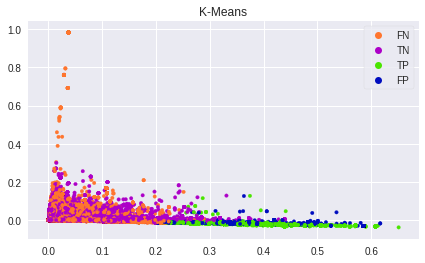


Confusion Matrix:  
 Predicted       0      1     All
True                            
0           60640   4827   65467
1           56907   8351   65258
All        117547  13178  130725

                    Classification Report 
               precision    recall  f1-score   support

           0       0.52      0.93      0.66     65467
           1       0.63      0.13      0.21     65258

   micro avg       0.53      0.53      0.53    130725
   macro avg       0.57      0.53      0.44    130725
weighted avg       0.57      0.53      0.44    130725



In [7]:
#if 1==0:
#-1	TN
#1	TP
#3	FP
#-3	FN

plt.figure(figsize=(7, 4))
# Calculate predicted values.
y_pred = km.fit_predict(X_train_lsa)

# Calculate Error Type
y_error = (y_pred*2)-Y_train

#Define Error Colors
LABEL_COLOR_MAP = {-1: '#FF752E',
                   0:  '#ad00c8',
                   1: '#4ae500', 
                   2: '#000dbf'
                   }
label_color = [LABEL_COLOR_MAP[i] for i in y_error]
label_convert = {-1: 'FN',
                 0: 'TN',
                 1:'TP',
                 2: 'FP'
                 } 
# Plot the solution.
plt.scatter(X_train_lsa[:, 0], X_train_lsa[:, 1],
            marker='.', c=label_color) 
#Plot the error legend
markers = [
    plt.Line2D([0, 0], [0, 0], color=color,
               marker='o', linestyle=''
               ) for color in LABEL_COLOR_MAP.values()]
plt.legend(markers, label_convert.values(), numpoints=1, frameon=True)
plt.rcParams.update({'font.size': 12})
plt.title('K-Means')
plt.savefig("K-Means.png", dpi =300)
files.download("K-Means.png")
plt.show()

# Check the solution against the data.
cm = pd.crosstab(Y_train, y_pred, rownames=['True'], 
                 colnames=['Predicted'], margins=True)
print("\nConfusion Matrix:  \n", cm)
print("\n                    Classification Report \n",
      classification_report(Y_train, y_pred))

# **Word2Vec**

In [0]:
from string import punctuation

# convert column of tweets to list of words
all_text = df3.clean.astype(str).values.tolist()
string_text = '\n'.join([word for word in all_text])
tweet_split = string_text.split('\n')
string_text = ' '.join(tweet_split)

# create a list of words
words = string_text.split()

In [0]:
if 1==0:  
  #text = " ".join(desc for desc in df.description)
  print ("There are {:,.0f} words in the combination of all descriptions.".format(
      len(string_text)))
  stopwords = set(STOPWORDS)
  #d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()
  twitter_mask = np.array(Image.open(
      '/content/gdrive/My Drive/Data Science/twitter.png'))
  wc = WordCloud(stopwords=stopwords, background_color="black", max_words=10000,
                        contour_width=3, mask=video_mask, contour_color='white').generate(text)

  wc.to_file(path.join(d, 'video_games.png'))

  fig, ax = plt.subplots(figsize=(20, 15))
  plt.imshow(wc, interpolation='bilinear')
  plt.axis('off')
  plt.show()

In [0]:
# store as list of lists of words
sentences = []
for sent_str in all_text:
    tokens = re.sub(r"[^a-z0-9]+", " ", sent_str.lower()).split()
    sentences.append(tokens)

In [11]:
sentences[0]

['can',
 'speak',
 'buzzfeed',
 'sourcing',
 'but',
 'for',
 'what',
 'worth',
 'declined',
 'run',
 'with',
 'parts',
 'the',
 'narrative',
 'they',
 'conveye']

In [0]:
from gensim.models import Word2Vec

w2v_model = Word2Vec(
    sentences=sentences, size=300, window=5, min_count=5, workers=4, sg=0)


In [13]:
w2v_model.wv.most_similar('bad')

[('busy', 0.42426571249961853),
 ('funny', 0.41591668128967285),
 ('good', 0.3762533962726593),
 ('expensive', 0.37471961975097656),
 ('dead', 0.3725906014442444),
 ('terrible', 0.37016820907592773),
 ('aware', 0.36373957991600037),
 ('irresponsible', 0.35501688718795776),
 ('sorry', 0.3536641001701355),
 ('badly', 0.3469257950782776)]

## **Fast Text**

In [0]:
from gensim.models import FastText
fast_model = FastText(
    sentences, size=300, window=5, min_count=5, workers=4,sg=0)

In [15]:
fast_model.wv.most_similar("bad")

[('badly', 0.6516428589820862),
 ('badass', 0.6447875499725342),
 ('load', 0.5793665051460266),
 ('dad', 0.548431932926178),
 ('abroad', 0.5226844549179077),
 ('glad', 0.5136569738388062),
 ('knead', 0.4804845452308655),
 ('road', 0.4780395030975342),
 ('brad', 0.4651046395301819),
 ('wad', 0.4579755365848541)]

# **Doc2Vec**

In [0]:
x_d2v = df3.clean
y_d2v = df3.SA2

x_train_d2v, x_validation_and_test_d2v, y_train_d2v, y_validation_and_test_d2v = train_test_split(
    x_d2v, y_d2v, test_size=.02, random_state=42)

x_validation_d2v, x_test_d2v, y_validation_d2v, y_test_d2v = train_test_split(
    x_validation_and_test_d2v, y_validation_and_test_d2v, 
    test_size=.5, random_state=42)

In [0]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from gensim.models.doc2vec import LabeledSentence
import multiprocessing
from sklearn import utils

In [0]:
def labelize_tweets_ug(tweets,label):
    result = []
    prefix = label
    for i, t in zip(tweets.index, tweets):
        result.append(LabeledSentence(t.split(), [prefix + '_%s' % i]))
    return result

We'll train with the entire 

In [0]:
all_x = pd.concat([x_train_d2v, x_validation_d2v, x_test_d2v])
all_x_w2v = labelize_tweets_ug(all_x, 'all')

In [20]:
len(all_x_w2v)

174300

In [21]:
doc2vec_model = Doc2Vec(vector_size=50, min_count=2, epochs=5)
doc2vec_model.build_vocab([x for x in tqdm(all_x_w2v)])

100%|██████████| 174300/174300 [00:00<00:00, 1120102.21it/s]


In [22]:
doc2vec_model.train(
    utils.shuffle([x for x in tqdm(all_x_w2v)]),
                        total_examples=len(all_x_w2v), 
    epochs=doc2vec_model.epochs)
   

100%|██████████| 174300/174300 [00:00<00:00, 1406082.31it/s]


In [0]:
def get_vectors(model, corpus, size):
    vecs = np.zeros((len(corpus), size))
    n = 0
    for i in corpus.index:
        prefix = 'all_' + str(i)
        vecs[n] = model.docvecs[prefix]
        n += 1
    return vecs
  
train_vecs_d2v = get_vectors(doc2vec_model, x_train_d2v, 50)
validation_vecs_d2v = get_vectors(doc2vec_model, x_validation_d2v, 50)  

In [0]:
# Defining a function to fit and predict ML algorithms
def auto_model(mod, model_name, X_train, X_test, y_train, y_test):
    mod.fit(X_train, y_train)
    print(model_name)
    acc = cross_val_score(mod, X_train, y_train,
                          scoring="accuracy", cv=5)
    predictions = cross_val_predict(mod, X_train, y_train, cv=5)
    print("Accuracy:", round(acc.mean(), 3))
    cm = pd.crosstab(y_train, predictions, rownames=['True'], 
                 colnames=['Predicted'], margins=True)
    print("\nConfusion Matrix:  \n", cm)
    print("\n                    Classification Report \n",
          classification_report(y_train, predictions))

## **Doc2Vec Classification Models**

In [25]:
# Random Forest Classifier
rfc = RandomForestClassifier(n_estimators=100, n_jobs=-1)
auto_model(rfc, "Random Forest Classifier",
           train_vecs_d2v, validation_vecs_d2v, y_train_d2v, y_validation_d2v)

Random Forest Classifier
Accuracy: 0.678

Confusion Matrix:  
 Predicted     -1      1     All
True                           
-1         60108  25328   85436
1          29747  55631   85378
All        89855  80959  170814

                    Classification Report 
               precision    recall  f1-score   support

          -1       0.67      0.70      0.69     85436
           1       0.69      0.65      0.67     85378

   micro avg       0.68      0.68      0.68    170814
   macro avg       0.68      0.68      0.68    170814
weighted avg       0.68      0.68      0.68    170814



In [26]:
# Gaussian Naive Bayes
gnb = GaussianNB()
auto_model(gnb, "Gaussian Naive Bayes", 
              train_vecs_d2v, validation_vecs_d2v, y_train_d2v, 
              y_validation_d2v)

Gaussian Naive Bayes
Accuracy: 0.528

Confusion Matrix:  
 Predicted     -1       1     All
True                            
-1         28321   57115   85436
1          23444   61934   85378
All        51765  119049  170814

                    Classification Report 
               precision    recall  f1-score   support

          -1       0.55      0.33      0.41     85436
           1       0.52      0.73      0.61     85378

   micro avg       0.53      0.53      0.53    170814
   macro avg       0.53      0.53      0.51    170814
weighted avg       0.53      0.53      0.51    170814



In [27]:
# Logistic Regression
log = LogisticRegression(solver='lbfgs')
auto_model(log, "Logistic Regression", train_vecs_d2v, validation_vecs_d2v, 
              y_train_d2v, y_validation_d2v)

Logistic Regression
Accuracy: 0.582

Confusion Matrix:  
 Predicted     -1      1     All
True                           
-1         49535  35901   85436
1          35547  49831   85378
All        85082  85732  170814

                    Classification Report 
               precision    recall  f1-score   support

          -1       0.58      0.58      0.58     85436
           1       0.58      0.58      0.58     85378

   micro avg       0.58      0.58      0.58    170814
   macro avg       0.58      0.58      0.58    170814
weighted avg       0.58      0.58      0.58    170814



In [28]:
# Linear SVC
svc = LinearSVC()
auto_model(svc, "Linear SVC", train_vecs_d2v, validation_vecs_d2v, 
              y_train_d2v, y_validation_d2v)

Linear SVC
Accuracy: 0.582

Confusion Matrix:  
 Predicted     -1      1     All
True                           
-1         49522  35914   85436
1          35517  49861   85378
All        85039  85775  170814

                    Classification Report 
               precision    recall  f1-score   support

          -1       0.58      0.58      0.58     85436
           1       0.58      0.58      0.58     85378

   micro avg       0.58      0.58      0.58    170814
   macro avg       0.58      0.58      0.58    170814
weighted avg       0.58      0.58      0.58    170814



In [29]:
df3.describe()

,Unnamed: 0,word_count,character_count,SA,SA2
count,174300.000000,174300.000000,174300.000000,174300.000000,174300.000000
mean,216112.418635,20.074412,130.227292,-0.021997,0.000000
std,123453.699298,4.729565,23.467064,0.959790,1.000003
min,1.000000,1.000000,4.000000,-1.000000,-1.000000
25%,110265.750000,18.000000,139.000000,-1.000000,-1.000000
50%,214889.500000,21.000000,140.000000,0.000000,0.000000
75%,322273.500000,23.000000,140.000000,1.000000,1.000000
max,430227.000000,32.000000,202.000000,1.000000,1.000000


# **Preparing Data for Pytorch**

In [0]:
from collections import Counter


## Build a dictionary that maps words to integers
counts = Counter(words)
vocab = sorted(counts, key=counts.get, reverse=True)
vocab_to_int = {word: ii for ii, word in enumerate(vocab, 1)}
  
## use the dict to tokenize each tweet in tweet_split
## store the tokenized tweet in tweet_ints
tweet_ints = []
for tweet in tweet_split:
    tweet_ints.append([vocab_to_int[word] for word in tweet.split()])

In [31]:
#vocab_to_int.keys()
print(tweet_split[0])
print(tweet_ints[0])

 can  speak  buzzfeed  sourcing but for what   worth  declined  run with parts  the narrative they conveye
[40, 202, 7, 253, 24, 5, 35, 220, 251, 118, 19, 134, 1, 198, 15, 257]


In [32]:

# stats about vocabulary
print('Unique words: ', len((vocab_to_int)))  
print()

Unique words:  33645



In [33]:
# outlier tweet stats
tweet_lens = Counter([len(x) for x in tweet_ints])
print("Zero-length tweets: {}".format(tweet_lens[0]))
print("Minimum tweet word count: {}".format(min(tweet_lens)))
print("Maximum tweet word count: {}".format(max(tweet_lens)))

Zero-length tweets: 0
Minimum tweet word count: 1
Maximum tweet word count: 25


In [0]:
def pad_features(tweet_ints, seq_length):
    ''' Return features of tweet_ints, where each tweet is padded with 0's 
        or truncated to the input seq_length.
    '''
    
    # getting the correct rows x cols shape
    features = np.zeros((len(tweet_ints), seq_length), dtype=int)

    # for each review, I grab that review and 
    for i, row in enumerate(tweet_ints):
        features[i, -len(row):] = np.array(row)[:seq_length]
    
    return features

In [0]:
# Test your implementation!

seq_length = 26

features = pad_features(tweet_ints, seq_length=seq_length)

## test statements - do not change - ##
assert len(features)==len(tweet_ints), "Your features should have as many rows as reviews."
assert len(features[0])==seq_length, "Each feature row should contain seq_length values."

# print last 20 values of the first 30 batches 
#features[:, 30:43]

In [36]:

split_frac = 0.8

## split data into training, validation, and test data (features and labels, x and y)

split_idx = int(len(features)*split_frac)
train_x, remaining_x = features[:split_idx], features[split_idx:]
train_y, remaining_y = encoded_labels[:split_idx], encoded_labels[split_idx:]

test_idx = int(len(remaining_x)*0.5)
val_x, test_x = remaining_x[:test_idx], remaining_x[test_idx:]
val_y, test_y = remaining_y[:test_idx], remaining_y[test_idx:]

## print out the shapes of your resultant feature data
print("\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(train_x.shape), 
      "\nValidation set: \t{}".format(val_x.shape),
      "\nTest set: \t\t{}".format(test_x.shape))

			Feature Shapes:
Train set: 		(139440, 26) 
Validation set: 	(17430, 26) 
Test set: 		(17430, 26)


## **DataLoaders and Batching**
After creating training, test, and validation data, we can create DataLoaders for this data by following two steps:

1.   Create a known format for accessing our data, using TensorDataset which takes in an input set of data and a target set of data with the same first dimension, and creates a dataset.
2.   Create DataLoaders and batch our training, validation, and test Tensor datasets


train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))

train_loader = DataLoader(train_data, batch_size=batch_size)

This is an alternative to creating a generator function for batching our data into full batches.

In [0]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
valid_data = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

# dataloaders
batch_size = 30

# make sure the SHUFFLE your training data
train_loader = DataLoader(train_data, shuffle=False, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=False, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)

In [38]:
torch.from_numpy(train_x)[17][:10]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [39]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print()
print('Sample label size: ', sample_y.size()) # batch_size
print('Sample label: \n', sample_y)

Sample input size:  torch.Size([30, 26])
Sample input: 
 tensor([[    0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            40,   202,     7,   253,    24,     5,    35,   220,   251,   118,
            19,   134,     1,   198,    15,   257],
        [    0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,    13,     7,    20,   184,     2,   119,    61,
            16,   237,     9,   125,   182,  1475],
        [    0,     0,     0,     0,     0,     0,     0,     1,   255,    29,
          1629,  7606,  4081,     5,    56,     2,    15, 13812,   603,   127,
             3,  2256,  5908,    47,     9,   131],
        [    0,     0,     0,     0,     0,     0,     0,     0,     0,    19,
           517,   461,     1,   155,    31,    29,   629,   102,  1640,    19,
             1,   142,    52,     2,    62,   287],
        [    0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,  

# Sentiment Network with PyTorch

LSTM Neural Networks, which stand for Long Short-Term Memory, are a particular type of recurrent neural networks. LSTM networks manage to keep contextual information of inputs by integrating a loop that allows information to flow from one step to the next. 

Since tweets are  composed from a sequence of words, and the specific order of those words provide context to the sentiment of the tweet, it stands to reason this Neural Network should predict tweet sentiment well. 

<img src="https://github.com/udacity/deep-learning-v2-pytorch/blob/master/sentiment-rnn/assets/network_diagram.png?raw=1" width=40%>

The layers are as follows:
1. An [embedding layer](https://pytorch.org/docs/stable/nn.html#embedding) that converts our word tokens (integers) into embeddings of a specific size.
2. An [LSTM layer](https://pytorch.org/docs/stable/nn.html#lstm) defined by a hidden_state size and number of layers
3. A fully-connected output layer that maps the LSTM layer outputs to a desired output_size
4. A sigmoid activation layer which turns all outputs into a value 0-1; return **only the last sigmoid output** as the output of this network.

### The Embedding Layer

We need to add an [embedding layer](https://pytorch.org/docs/stable/nn.html#embedding) because there are tens of thousands of words in our vocabulary. It is massively inefficient to one-hot encode that many classes. So, instead of one-hot encoding, we can have an embedding layer and use that layer as a lookup table.** I could train an embedding layer using Word2Vec, then load it here. But, it's recommended to just make a new layer, using it for only dimensionality reduction, and let the network learn the weights.**


### The LSTM Layer(s)

We'll create an [LSTM](https://pytorch.org/docs/stable/nn.html#lstm) to use in our recurrent network, which takes in an input_size, a hidden_dim, a number of layers, a dropout probability (for dropout between multiple layers), and a batch_first parameter.





In [40]:
# First checking if GPU is available
train_on_gpu=torch.cuda.is_available()

if(train_on_gpu):
    print('Training on GPU.')
else:
    print('No GPU available, training on CPU.')

Training on GPU.


In [0]:

import torch.nn as nn

class SentimentRNN(nn.Module):
    """
    The RNN model that will be used to perform Sentiment analysis.
    """

    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        """
        Initialize the model by setting up the layers.
        """
        super(SentimentRNN, self).__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, 
                            dropout=drop_prob, batch_first=True)
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
        
        # linear and sigmoid layers
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sig = nn.Sigmoid()
        

    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)

        # embeddings and lstm_out
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
    
        # stack up lstm outputs
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        # dropout and fully-connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        # sigmoid function
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return sig_out, hidden
    
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim
                                ).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim
                            ).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim
                                ).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim
                                ).zero_())
        
        return hidden

## Instantiate the network

Here, we'll instantiate the network. First up, defining the hyperparameters.

* `vocab_size`: Size of our vocabulary or the range of values for our input, word tokens.
* `output_size`: Size of our desired output; the number of class scores we want to output (pos/neg).
* `embedding_dim`: Number of columns in the embedding lookup table; size of our embeddings.
* `hidden_dim`: Number of units in the hidden layers of our LSTM cells. Usually larger is better performance wise. Common values are 128, 256, 512, etc.
* `n_layers`: Number of LSTM layers in the network. Typically between 1-3

In [42]:
len(vocab_to_int)

33645

In [43]:
# Instantiate the model w/ hyperparams
vocab_size = len(vocab_to_int)+1 # +1 for the 0 padding + our word tokens
output_size = 1
embedding_dim = 300
hidden_dim = 256
n_layers = 2

net = SentimentRNN(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)

print(net)

SentimentRNN(
  (embedding): Embedding(33646, 300)
  (lstm): LSTM(300, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


## Training
​
Below is the typical training code. 
​
>We'll also be using a new kind of cross entropy loss, which is designed to work with a single Sigmoid output. [BCELoss](https://pytorch.org/docs/stable/nn.html#bceloss), or **Binary Cross Entropy Loss**, applies cross entropy loss to a single value between 0 and 1.
​
We also have some data and training hyparameters:
​
* `lr`: Learning rate for our optimizer.
* `epochs`: Number of times to iterate through the training dataset.
* `clip`: The maximum gradient value to clip at (to prevent exploding gradients).

In [0]:
# loss and optimization functions
lr=0.001

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

In [45]:

# training params

epochs = 1 # 3-4 is approx where I noticed the validation loss stop decreasing

counter = 0
print_every = 100
clip=5 # gradient clipping

train_loss = []
val_loss1 = []

# move model to GPU, if available
if(train_on_gpu):
    net.cuda()

net.train()
# train for some number of epochs
for e in range(epochs):
    # initialize hidden state
    h = net.init_hidden(batch_size)

    # batch loop
    for inputs, labels in train_loader:
        counter += 1

        if(train_on_gpu):
            inputs, labels = inputs.cuda(), labels.cuda()

        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        # zero accumulated gradients
        net.zero_grad()

        # get the output from the model
        output, h = net(inputs, h)

        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()

        # loss stats
        if counter % print_every == 0:
            # Get validation loss
            val_h = net.init_hidden(batch_size)
            val_losses = []
            net.eval()
            for inputs, labels in valid_loader:

                # Creating new variables for the hidden state, otherwise
                # we'd backprop through the entire training history
                val_h = tuple([each.data for each in val_h])

                if(train_on_gpu):
                    inputs, labels = inputs.cuda(), labels.cuda()

                output, val_h = net(inputs, val_h)
                val_loss = criterion(output.squeeze(), labels.float())

                val_losses.append(val_loss.item())

            net.train()
          
            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))
            train_loss.append(loss.item())
            val_loss1.append(np.mean(val_losses))
           

Epoch: 1/1... Step: 100... Loss: 0.302807... Val Loss: 0.355550
Epoch: 1/1... Step: 200... Loss: 0.318893... Val Loss: 0.306834
Epoch: 1/1... Step: 300... Loss: 0.409422... Val Loss: 0.240995
Epoch: 1/1... Step: 400... Loss: 0.429408... Val Loss: 0.203734
Epoch: 1/1... Step: 500... Loss: 0.180348... Val Loss: 0.192421
Epoch: 1/1... Step: 600... Loss: 0.093724... Val Loss: 0.177341
Epoch: 1/1... Step: 700... Loss: 0.070842... Val Loss: 0.157524
Epoch: 1/1... Step: 800... Loss: 0.174517... Val Loss: 0.150262
Epoch: 1/1... Step: 900... Loss: 0.119679... Val Loss: 0.134762
Epoch: 1/1... Step: 1000... Loss: 0.102350... Val Loss: 0.134548
Epoch: 1/1... Step: 1100... Loss: 0.140906... Val Loss: 0.132185
Epoch: 1/1... Step: 1200... Loss: 0.090213... Val Loss: 0.122376
Epoch: 1/1... Step: 1300... Loss: 0.184524... Val Loss: 0.123232
Epoch: 1/1... Step: 1400... Loss: 0.071671... Val Loss: 0.109137
Epoch: 1/1... Step: 1500... Loss: 0.036419... Val Loss: 0.116654
Epoch: 1/1... Step: 1600... Loss: 

## **Testing the Network**

In [46]:
# Get test data loss and accuracy

test_losses = [] # track loss
num_correct = 0
pred_tens = [] # Track preds

# init hidden state
h = net.init_hidden(batch_size)

net.eval()
# iterate over test data
for inputs, labels in test_loader:

    # Creating new variables for the hidden state, otherwise
    # we'd backprop through the entire training history
    h = tuple([each.data for each in h])

    if(train_on_gpu):
        inputs, labels = inputs.cuda(), labels.cuda()
    
    # get predicted outputs
    output, h = net(inputs, h)
    
    # calculate loss
    test_loss = criterion(output.squeeze(), labels.float())
    test_losses.append(test_loss.item())
    
    # convert output probabilities to predicted class (0 or 1)
    pred = torch.round(output.squeeze())  # rounds to the nearest integer
    pred_tens.append(pred.cpu().detach().numpy())
    
    # compare predictions to true label
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)


# -- stats! -- ##
# avg test loss
print("Test loss: {:.3f}".format(np.mean(test_losses)))

# accuracy over all test data
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f}".format(test_acc))

#Flatten list of lists containing predictions
flat_list = [item.astype(int) for sublist in pred_tens for item in sublist]

#Convert list to np array
pred_array = np.asarray(flat_list)

# Check the solution against the data.
cm = pd.crosstab(pred_array, test_y, rownames=['True'], 
                 colnames=['Predicted'], margins=True)
print("\nConfusion Matrix:  \n", cm)
print("\n                    Classification Report \n",
      classification_report(flat_list, test_y))

Test loss: 0.045
Test accuracy: 0.984

Confusion Matrix:  
 Predicted     0     1    All
True                        
0          8584   108   8692
1           166  8572   8738
All        8750  8680  17430

                    Classification Report 
               precision    recall  f1-score   support

           0       0.98      0.99      0.98      8692
           1       0.99      0.98      0.98      8738

   micro avg       0.98      0.98      0.98     17430
   macro avg       0.98      0.98      0.98     17430
weighted avg       0.98      0.98      0.98     17430



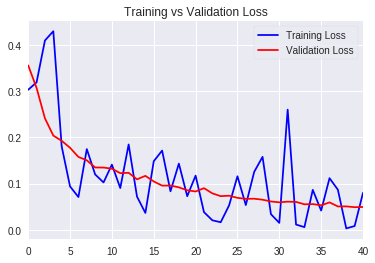

In [47]:
fig=plt.figure()
fig.show()
ax=fig.add_subplot(111)
ax.plot(train_loss, c='b', label='Training Loss')
ax.plot(val_loss1, c='r', label='Validation Loss')
plt.xlim(0,40)

plt.legend(loc='upper right', frameon=True)
plt.title('Training vs Validation Loss')
plt.savefig('trainvalloss.png', dpi=300)
files.download('trainvalloss.png')
plt.show()

## **Validating the Classifier**

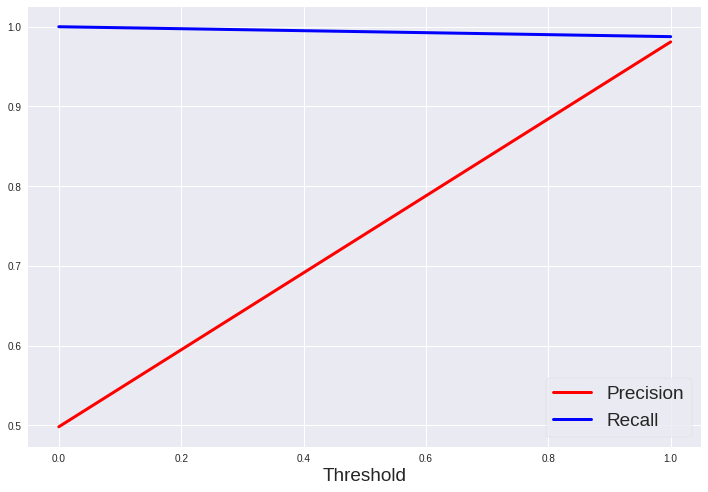

In [48]:
# Precison Recall Curve

precision, recall, threshold = precision_recall_curve(test_y, pred_array)

# Defining a new function to plot the precision-recall curve
def plot_precision_and_recall(precision, recall, threshold):
    plt.plot(threshold, precision[:-1], "r-", label="Precision", linewidth=3)
    plt.plot(threshold, recall[:-1], "b", label="Recall", linewidth=3)
    plt.xlabel("Threshold", fontsize=19)
    plt.legend(loc="lower right", fontsize=19, frameon=True)

plt.figure(figsize=(10, 7))
plot_precision_and_recall(precision, recall, threshold)
plt.tight_layout()
#plt.savefig('Precision Recall.png', dpi=300)
#files.download('Precision Recall.png')
plt.show()

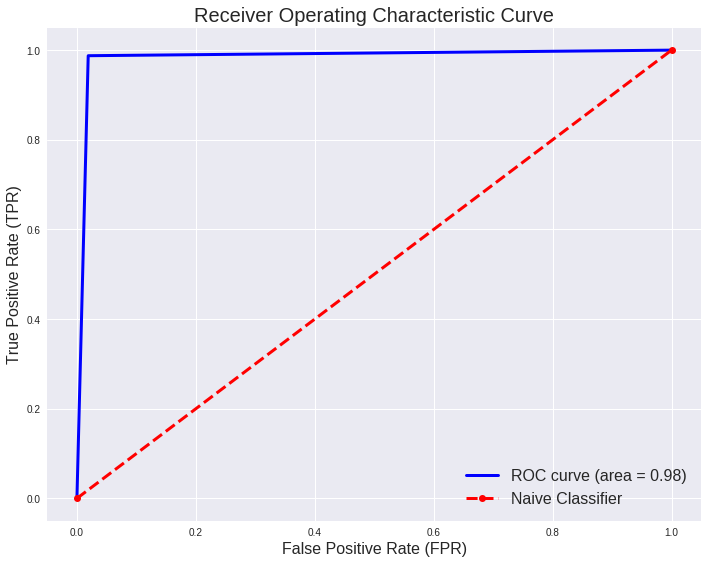

In [49]:
# ROC Curve

# Compute the true positive and false positive rate
false_positive_rate, true_positive_rate, thresholds = roc_curve(
    test_y, pred_array)

# Plotting the true positive and false positive rate
def plot_roc_curve(false_positive_rate, true_positive_rate, label=None):
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    plt.plot(false_positive_rate, true_positive_rate, 'b',
             linewidth=3, label='ROC curve (area = {0:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], 'ro--', label='Naive Classifier',
             linewidth=3)
    plt.xlabel('False Positive Rate (FPR)', fontsize=16)
    plt.ylabel('True Positive Rate (TPR)', fontsize=16)
    plt.legend(loc="lower right", fontsize=16)

plt.figure(figsize=(10, 8))
plot_roc_curve(false_positive_rate, true_positive_rate)
plt.title('Receiver Operating Characteristic Curve', size = 20)
plt.tight_layout()
#plt.savefig('ROC Curve.png', dpi=300)
#files.download('ROC Curve.png')
plt.show()

In [0]:
#torch.save(net.state_dict(), '/content/gdrive/My Drive/Data Science/net.pth')

In [0]:
#PATH = '/content/gdrive/My Drive/Data Science'
#torch.save(
#SentimentRNN, '/content/gdrive/My Drive/Data Science/SentimentRNN.pth')


## Testing Brand New Tweets

In [0]:
from string import punctuation

def tokenize_comment(test_comment):
    
    # Remove URLs
    test_comment = test_comment.replace('https?://[A-Za-z0-9./]+','')
    
    # Keep Hashtag text
    test_comment = test_comment.replace("[^a-zA-Z]", " ")
    
    # Remove whitespace
    #test_comment = test_comment.replace(' ', '')
    
    # Remove 1-2 letter words
    test_comment = test_comment.replace("r'\b\w{1,2}\b", '')
    
    # Remove numbers
    test_comment = test_comment.replace('\d+', '')
    
    # Lowercase
    test_comment = test_comment.lower() # lowercase
    
    # get rid of punctuation
    test_text = ''.join([c for c in test_comment if c not in punctuation])
    
    # Remove Stopwords
    #test_text = ''.join([word for word in test_text.split() if word not in (stop)])
    
    # splitting by spaces
    test_words = [word for word in test_text.split() if word not in (stop)]

    # tokens
    test_ints = []
    test_ints.append([vocab_to_int[word] for word in test_words if word in vocab])

    return test_ints


In [0]:
# test sequence padding
#seq_length=26
#neg_features = pad_features(test_ints_neg, seq_length)
#pos_features = pad_features(test_ints_pos, seq_length)

In [0]:
# test conversion to tensor and pass into your model
#neg_feature_tensor = torch.from_numpy(neg_features)
#pos_feature_tensor = torch.from_numpy(pos_features)

In [0]:
def predict(net, test_comment, sequence_length=43):
    
    net.eval()
    
    # tokenize review
    test_ints = tokenize_comment(test_comment)
    
    # pad tokenized sequence
    seq_length=sequence_length
    features = pad_features(test_ints, seq_length)
    
    # convert to tensor to pass into your model
    feature_tensor = torch.from_numpy(features)
    
    batch_size = feature_tensor.size(0)
    
    # initialize hidden state
    h = net.init_hidden(batch_size)
    
    if(train_on_gpu):
        feature_tensor = feature_tensor.cuda()
    
    # get the output from the model
    output, h = net(feature_tensor, h)
    
    # convert output probabilities to predicted class (0 or 1)
    pred = torch.round(output.squeeze()) 
    # printing output value, before rounding
    print('Prediction value, pre-rounding: {:.6f}'.format(output.item()))
    
    # print custom response
    if(pred.item()==1):
        print("Positive comment detected!")
    else:
        print("Negative comment detected.")

In [0]:
# negative test comment
test_comment_neg = "Ashamed of my country today. This ban in hurtful and completely unnecessary. @realDonaldTrump, for someone so seemingly obsessed with national security, why are you stripping the rights of people who just want to protect us?! #transmilitaryban"
test_comment_neg2 = "This is bad!"
live_test_neg = ""

# positive test comment
test_comment_pos = "Christopher Nolan is the kind of man who is given a release date for a film that has no title, probably just a draft of a script, and no cast. If that’s not POWER than I don’t know what is. #ChristopherNolan #King"
test_comment_pos2 = "This is good."
live_test_pos = ""

In [58]:
# Negative test 1
seq_length=26 # good to use the length that was trained on

predict(net, test_comment_neg, seq_length)

Prediction value, pre-rounding: 0.012674
Negative comment detected.


In [59]:
# Negative test 2
seq_length=26 
predict(net, test_comment_neg2, seq_length)

Prediction value, pre-rounding: 0.000890
Negative comment detected.


In [60]:
# Positive Test 1
seq_length=26 

predict(net, test_comment_pos, seq_length)

Prediction value, pre-rounding: 0.999644
Positive comment detected!


In [61]:
# Positive Test 2
seq_length=26 
predict(net, test_comment_pos2, seq_length)

Prediction value, pre-rounding: 0.999474
Positive comment detected!


In [0]:
if 1==0:
  # Live test 
  seq_length=26 
  print(predict(net, live_test_pos, seq_length))
  print('\n')
  print(predict(net, live_test_neg, seq_length))

# **Conclusion**









1.  The LSTM RNN was better at classifiying tweets as positive or negative as compared to a Random Forest Classifier.
2.  The presence of stop words does not seem to impair the RNN.
3. The RNN does struggle with short and simple negative comments. This could be due to:

    *   The limited vocabulary present in the corpus.
    *   A lack of context.
 

# **Future Work**




*   The next investigative work I plan to do is to feed the RNN an embedding layer trained with Word2Vec or Sense2Vec weights. This could illuminate if the contextual issue is why the test string failed.
* Additionally I will investigate using part of pseech tagging to improve the model.
*   I would also like to add more data to my dataset, pulling tweets using filters based on product brands and entertainment. 
* Lastly I would like to develop a multi label classifier that predicts neutral sentiment as well.

